# Week 10: Logistic Regression and Generalized Linear Models

### Neil D. Lawrence

### 1st December 2015

In [2]:
import numpy as np
import pandas as pd
import pods
import matplotlib.pyplot as plt
%matplotlib inline

### Review

* Last week: Specified Class Conditional Distributions, $p(\mathbf{x}_i|y_i, \boldsymbol{\theta})$.
* Used Bayes Classifier + naive Bayes model to specify joint distribtuion.
* Used Bayes rule to compute posterior probability of class membership.
* This week: 
    * direct estimation of probability of class membership.
    * introduction of generalised linear models.


### Logistic Regression and GLMs

* Modelling entire density allows any question to be answered (also missing data).
* Comes at the possible expense of *strong* assumptions about data generation distribution.
* In regression we model probability of $y_i |\mathbf{x}_i$ directly.
    * **Allows less flexibility in the question, but more flexibility in the model assumptions.**
* Can do this not just for regression, but classification.
* Framework is known as *generalized linear models*.

## Log Odds

* model the *log-odds* with the basis functions.
* [odds](http://en.wikipedia.org/wiki/Odds) are defined as the ratio of the probability of a positive outcome, to the probability of a negative outcome. 
* Probability is between zero and one, odds are:
    $$ \frac{\pi}{1-\pi} $$
* Odds are between $0$ and $\infty$. 
* Logarithm of odds maps them to $-\infty$ to $\infty$.

### Logit Link Function

* The [Logit function](http://en.wikipedia.org/wiki/Logit), $$g^{-1}(\pi_i) = \log\frac{\pi_i}{1-\pi_i}.$$ This function is known as a *link function*.

* For a standard regression we take,
    $$f(\mathbf{x}_i) = \mathbf{w}^\top \boldsymbol{\phi}(\mathbf{x}_i),$$
* For classification we perform a logistic regression. 
    $$\log \frac{\pi_i}{1-\pi_i} = \mathbf{w}^\top \boldsymbol{\phi}(\mathbf{x}_i)$$

### Inverse Link Function

We have defined the link function as taking the form $g^{-1}(\cdot)$ implying that the inverse link function is given by $g(\cdot)$. Since we have defined,
$$
g^{-1}(\pi) = \mathbf{w}^\top \boldsymbol{\phi}(\mathbf{x})
$$
we can write $\pi$ in terms of the *inverse link* function, $g(\cdot)$ as 
$$
\pi = g(\mathbf{w}^\top \boldsymbol{\phi}(\mathbf{x})).
$$

In [ ]:
def predict(w, x, basis=linear, **kwargs):
    "Generates the prediction function and the basis matrix."
    Phi = basis(x, **kwargs)
    f = np.dot(Phi, w)
    return 1./(1+np.exp(-f)), Phi

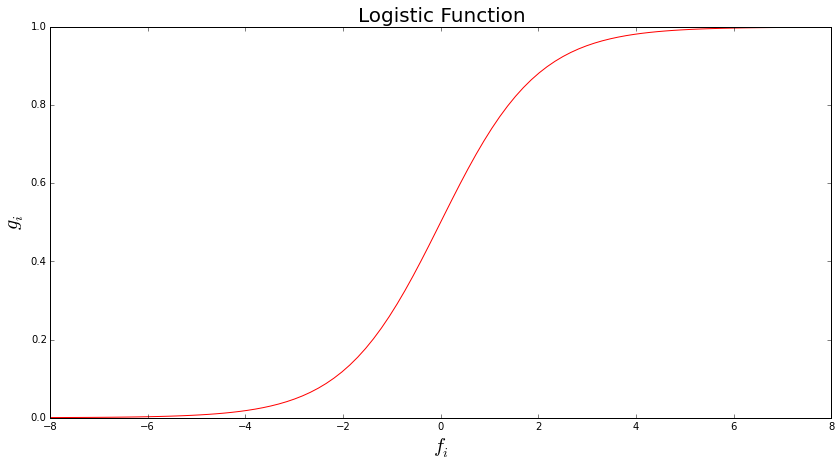

In [9]:
fig, ax = plt.subplots(figsize=(14,7))
f = np.linspace(-8, 8, 100)
g = 1/(1+np.exp(-f))

ax.plot(f, g, 'r-')
ax.set_title('Logistic Function', fontsize=20)
ax.set_xlabel('$f_i$', fontsize=20)
ax.set_ylabel('$g_i$', fontsize=20)
plt.savefig('./diagrams/logistic.svg')

This inverse of the link function is known as the [logistic](http://en.wikipedia.org/wiki/Logistic_function) (thus the name logistic regression) or sometimes it is called the sigmoid function. For a particular value of the input to the link function, $f_i = \mathbf{w}^\top \boldsymbol{\phi}(\mathbf{x}_i)$ we can plot the value of the link function as below.
![](./diagrams/logistic.svg)

### Sigmoid Function

* Logistic takes input from the entire real line and 'squashes' it between 0 and 1 it is sometimes also called a 'squashing function'. 

* Can now write $\pi$ as a function of the input and the parameter vector as, $$\pi(\mathbf{x},\mathbf{w}) = \frac{1}{1+ \exp\left(-\mathbf{w}^\top \boldsymbol{\phi}(\mathbf{x})\right)}.$$

* Compute the output of a standard linear basis function composition ($\mathbf{w}^\top \boldsymbol{\phi}(\mathbf{x})$, as we did for linear regression)

* Apply the inverse link function, $g(\mathbf{w}^\top \boldsymbol{\phi}(\mathbf{x}))$. 

* Use this value in a Bernoulli distribution to form the likelihood. 

### Bernoulli Reminder

* From last time $$P(y_i|\mathbf{w}, \mathbf{x}) = \pi_i^{y_i} (1-\pi_i)^{1-y_i}$$

* Trick for switching betwen probabilities
```python
def bernoulli(y, pi):
    if y == 1:
        return pi
    else:
        return 1-pi
```

### Maximum Likelihood

* Conditional independence of data:$$P(\mathbf{y}|\mathbf{w}, \mathbf{X}) = \prod_{i=1}^n P(y_i|\mathbf{w}, \mathbf{x}_i). $$
* Log likelihood
$$\log P(\mathbf{y}|\mathbf{w}, \mathbf{X}) = \sum_{i=1}^n \log P(y_i|\mathbf{w}, \mathbf{x}_i) = \sum_{i=1}^n y_i \log \pi_i + \sum_{i=1}^n (1-y_i)\log (1-\pi_i)$$

### Objective Function

* Probability of positive outcome for the $i$th data point $$\pi_i = g\left(\mathbf{w}^\top \boldsymbol{\phi}(\mathbf{x}_i)\right),$$ where $g(\cdot)$ is the *inverse* link function

* Objective function of the form $$E(\mathbf{w}) = -  \sum_{i=1}^n y_i \log g\left(\mathbf{w}^\top \boldsymbol{\phi}(\mathbf{x}_i)\right) - \sum_{i=1}^n(1-y_i)\log \left(1-g\left(\mathbf{w}^\top \boldsymbol{\phi}(\mathbf{x}_i)\right)\right).$$

In [ ]:
def objective(g, y):
    "Computes the objective function."
    return np.log(g[y.values, :]).sum() + np.log(1-g[~y.values, :]).sum()


### Minimize Objective

* Grdient wrt  $\pi(\mathbf{x};\mathbf{w})$ 
$$
\frac{\text{d}E(\mathbf{w})}{\text{d}\mathbf{w}} = -\sum_{i=1}^n \frac{y_i}{g\left(\mathbf{w}^\top \boldsymbol{\phi}(\mathbf{x})\right)}\frac{\text{d}g(f_i)}{\text{d}f_i} \boldsymbol{\phi(\mathbf{x}_i)} +  \sum_{i=1}^n \frac{1-y_i}{1-g\left(\mathbf{w}^\top \boldsymbol{\phi}(\mathbf{x})\right)}\frac{\text{d}g(f_i)}{\text{d}f_i} \boldsymbol{\phi(\mathbf{x}_i)}
$$

### Link Function Gradient

* Also need gradient of inverse link function wrt parameters.
\begin{align*}
g(f_i) &= \frac{1}{1+\exp(-f_i)}\\
&=(1+\exp(-f_i))^{-1}
\end{align*}
and the gradient can be computed as
\begin{align*}
\frac{\text{d}g(f_i)}{\text{d} f_i} & = \exp(-f_i)(1+\exp(-f_i))^{-2}\\
& = \frac{1}{1+\exp(-f_i)} \frac{\exp(-f_i)}{1+\exp(-f_i)} \\
& = g(f_i) (1-g(f_i))
\end{align*}

### Objective Gradient

$$
\frac{\text{d}E(\mathbf{w})}{\text{d}\mathbf{w}} = -\sum_{i=1}^n y_i\left(1-g\left(\mathbf{w}^\top \boldsymbol{\phi}(\mathbf{x})\right)\right) \boldsymbol{\phi(\mathbf{x}_i)} +  \sum_{i=1}^n (1-y_i)\left(g\left(\mathbf{w}^\top \boldsymbol{\phi}(\mathbf{x})\right)\right) \boldsymbol{\phi(\mathbf{x}_i)}.
$$

In [ ]:
def gradient(g, Phi, y):
    "Generates the gradient of the parameter vector."
    dw = -(Phi[y.values, :]*(1-g[y.values, :])).sum(0)
    dw += (Phi[~y.values, :]*g[~y.values, :]).sum(0)
    return dw[:, None]

### Optimization of the Function

Reorganizing the gradient to find a stationary point of the function with respect to the parameters $\mathbf{w}$ turns out to be impossible. Optimization has to proceed by *numerical methods*. Options include the multidimensional variant of [Newton's method](http://en.wikipedia.org/wiki/Newton%27s_method) or [gradient based optimization methods](http://en.wikipedia.org/wiki/Gradient_method) like we used for optimizing matrix factorization for the movie recommender system. We recall from matrix factorization that, for large data, *stochastic gradient descent* or the Robbins Munroe optimization procedure worked best for function minimization. 

In [ ]:
def linear(x, **kwargs):
    "Defines the linear basis."
    return np.hstack([np.ones((X.shape[0], 1)), X])

### Gradient Descent

We will need to define some initial random values for our vector and then minimize the objective by descending the gradient.

In [ ]:
# gradient descent algorithm
w = np.random.normal(size=(X.shape[1]+1, 1), scale = 0.001)
eta = 1e-9
iters = 10000
for i in range(iters):
    g, Phi = predict(w, X, linear)
    w -= eta*gradient(g, Phi, y)
    if not i % 100:
        print("Iter", i, "Objective", objective(g, y))

Let's look at the weights and how they relate to the inputs. 

In [ ]:
pd.Series(w.flatten(), index=['Eins'] + list(X.columns))

The weights are fairly small. This makes sense for year, and perhaps also body count, but given the genre only take the value of 0 or 1 it makes less sense for them. Why are the weights so small? What can you do to fix this?

### Stochastic Gradient Descent

Now construct a stochastic gradient descent algorithm and run it on the data. Is it faster or slower than batch gradient descent? What can you do to improve convergence speed?



### Ad Matching for Facebook

## Going Further

### Optimization

Other optimization techniques for generalized linear models include [Newton's method](http://en.wikipedia.org/wiki/Newton%27s_method), it requires you to compute the Hessian, or second derivative of the objective function. 

Methods that are based on gradients only include [L-BFGS](http://en.wikipedia.org/wiki/Limited-memory_BFGS) and [conjugate gradients](http://en.wikipedia.org/wiki/Conjugate_gradient_method). Can you find these in python? Are they suitable for very large data sets? 

### Other GLMs

We've introduced the formalism for generalized linear models. Have a think about how you might model count data using the [Poisson distribution](http://en.wikipedia.org/wiki/Poisson_distribution) and a log link function for the rate, $\lambda(\mathbf{x})$. If you want a data set you can try the `pods.datasets.google_trends()` for some count data.

### Poisson Regression

